<a href="https://colab.research.google.com/github/mangoubi/DS595-ST-Machine-Learning-for-Engineering-Science-Applications/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Pytorch code trains a GAN which learns how to generate fake MNIST digits  (Code adapted from: https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.**ipynb** )

We first load the different python and pytorch packages that we will need:

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Generating a random fake image using the Generator neural network

In [6]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

Building the Discriminator neural network

In [7]:

class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

Building the Generator neural network

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_


In [9]:
n_noise = 100

In [10]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [11]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

Importing the MNIST dataset

In [12]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Setting the Batch size

In [13]:
batch_size = 64


In [14]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)


Defining the optimization algorithm(s) used by the generator and discriminator, and setting their hyperparameters

In [15]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


Setting the number of epochs

In [16]:
max_epoch = 11 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator


In [17]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [18]:
if not os.path.exists('samples'):
    os.makedirs('samples')

Training the GAN using Gradient Descent-Ascent (GDA)

In [19]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
      # Training Discriminator
       
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
       

        
        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = criterion(z_outputs, D_labels)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/11, Step: 0, D Loss: 1.432244062423706, G Loss: 0.6643311381340027
Epoch: 0/11, Step: 500, D Loss: 1.2189610004425049, G Loss: 0.709945797920227
Epoch: 1/11, Step: 1000, D Loss: 1.2966513633728027, G Loss: 0.9230072498321533
Epoch: 1/11, Step: 1500, D Loss: 1.4011626243591309, G Loss: 0.5753993988037109
Epoch: 2/11, Step: 2000, D Loss: 1.2528560161590576, G Loss: 0.8473408818244934
Epoch: 2/11, Step: 2500, D Loss: 1.182161808013916, G Loss: 0.9281086325645447
Epoch: 3/11, Step: 3000, D Loss: 1.2593637704849243, G Loss: 1.0231279134750366
Epoch: 3/11, Step: 3500, D Loss: 1.2107751369476318, G Loss: 1.0305076837539673
Epoch: 4/11, Step: 4000, D Loss: 1.1945908069610596, G Loss: 0.9481137990951538
Epoch: 4/11, Step: 4500, D Loss: 1.2598533630371094, G Loss: 1.0102843046188354
Epoch: 5/11, Step: 5000, D Loss: 1.2891442775726318, G Loss: 0.7699394226074219
Epoch: 5/11, Step: 5500, D Loss: 1.3003803491592407, G Loss: 0.607528805732727
Epoch: 6/11, Step: 6000, D Loss: 1.2627036571502

Generating random fake images using the generator from the trained GAN

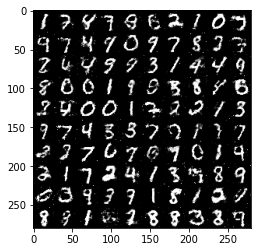

In [24]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')